![问题描述](1.png)

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math
from IPython.display import display, HTML

# 设置中文显示（如果需要）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

In [2]:
# 创建项目数据
project_data = {
    'Activity': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'Description': ['地基施工', '结构框架', '屋顶', '墙体施工', '电气安装', '管道安装', '内部装修', '外部装修', '图书上架', '验收'],
    'Predecessors': ['', 'A', 'B', 'B', 'D', 'D', 'E,F', 'C,D', 'G', 'H,I'],
    'CPM_Duration': [5, 8, 4, 6, 3, 4, 7, 5, 3, 2],
    'PERT_a': [4, 6, 3, 5, 2, 3, 5, 4, 2, 1],
    'PERT_m': [5, 8, 4, 6, 3, 4, 7, 5, 3, 2],
    'PERT_b': [9, 10, 8, 10, 7, 8, 12, 9, 7, 3]
}

# 创建DataFrame
df = pd.DataFrame(project_data)
display(HTML("<h2>1. 项目作业数据</h2>"))
display(df)

,Activity,Description,Predecessors,CPM_Duration,PERT_a,PERT_m,PERT_b
0,A,地基施工,,5,4,5,9
1,B,结构框架,A,8,6,8,10
2,C,屋顶,B,4,3,4,8
3,D,墙体施工,B,6,5,6,10
4,E,电气安装,D,3,2,3,7
5,F,管道安装,D,4,3,4,8
6,G,内部装修,"E,F",7,5,7,12
7,H,外部装修,"C,D",5,4,5,9
8,I,图书上架,G,3,2,3,7
9,J,验收,"H,I",2,1,2,3


,Activity,Description,Predecessors,CPM_Duration,PERT_a,PERT_m,PERT_b,ES,EF,LS,LF,Total_Float,Critical
0,A,地基施工,,5,4,5,9,0,5,0,5,0,是
1,B,结构框架,A,8,6,8,10,5,13,5,13,0,是
2,C,屋顶,B,4,3,4,8,13,17,24,28,11,否
3,D,墙体施工,B,6,5,6,10,13,19,13,19,0,是
4,E,电气安装,D,3,2,3,7,19,22,20,23,1,否
5,F,管道安装,D,4,3,4,8,19,23,19,23,0,是
6,G,内部装修,"E,F",7,5,7,12,23,30,23,30,0,是
7,H,外部装修,"C,D",5,4,5,9,19,24,28,33,9,否
8,I,图书上架,G,3,2,3,7,30,33,30,33,0,是
9,J,验收,"H,I",2,1,2,3,33,35,33,35,0,是


/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_39663/2419622158.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32476 (\N{CJK UNIFIED IDEOGRAPH-7EDC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font

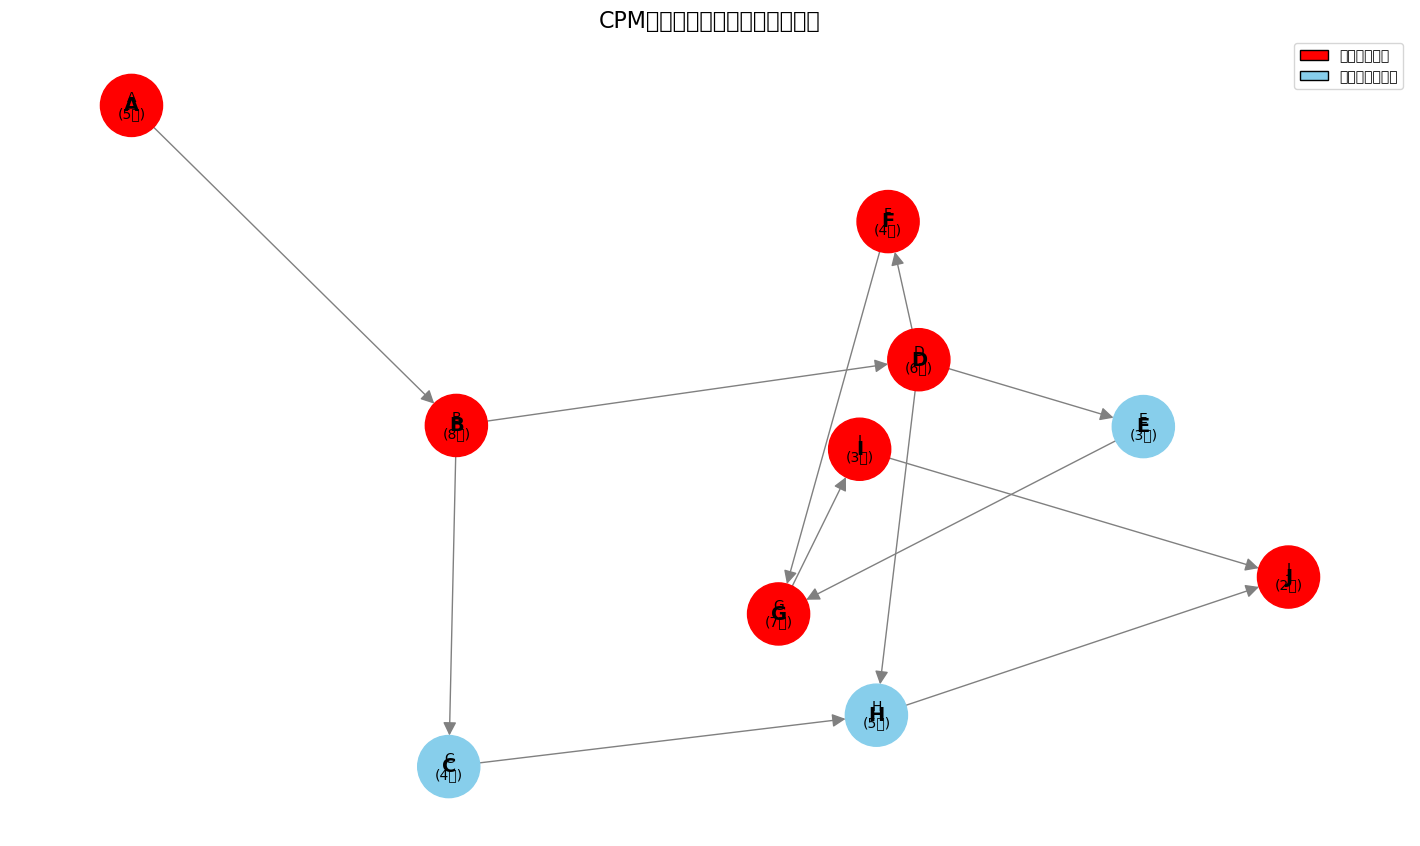

In [3]:
def cpm_analysis(df):
    """执行CPM分析，计算关键路径"""
    
    # 创建有向图
    G = nx.DiGraph()
    
    # 添加节点（每个活动作为一个节点）
    for _, row in df.iterrows():
        G.add_node(row['Activity'], duration=row['CPM_Duration'])
    
    # 添加边（基于前置作业）
    for _, row in df.iterrows():
        if row['Predecessors']:
            for pred in row['Predecessors'].split(','):
                G.add_edge(pred, row['Activity'])
    
    # 计算最早开始时间(ES)和最早完成时间(EF)
    es = {node: 0 for node in G.nodes}
    ef = {}
    
    # 按拓扑排序处理节点
    for node in nx.topological_sort(G):
        if list(G.predecessors(node)):
            es[node] = max(ef[pred] for pred in G.predecessors(node))
        ef[node] = es[node] + G.nodes[node]['duration']
    
    # 计算最晚开始时间(LS)和最晚完成时间(LF)
    # 从最后一个节点开始（假设只有一个结束节点）
    end_node = [node for node in G.nodes if not list(G.successors(node))][0]
    total_duration = ef[end_node]
    
    lf = {end_node: total_duration}
    ls = {}

    # 逆拓扑排序
    for node in reversed(list(nx.topological_sort(G))):
        if node == end_node:
            ls[node] = lf[node] - G.nodes[node]['duration']
            continue
            
        if list(G.successors(node)):
            lf[node] = min(ls[succ] for succ in G.successors(node))
        else:
            lf[node] = total_duration
            
        ls[node] = lf[node] - G.nodes[node]['duration']
    
    # 计算总时差(Total Float)
    total_float = {node: ls[node] - es[node] for node in G.nodes}
    
    # 确定关键路径（总时差为0的活动）
    critical_path = [node for node, tf in total_float.items() if tf == 0]

    # 将结果添加到DataFrame
    df_cpm = df.copy()
    df_cpm['ES'] = [es[act] for act in df_cpm['Activity']]
    df_cpm['EF'] = [ef[act] for act in df_cpm['Activity']]
    df_cpm['LS'] = [ls[act] for act in df_cpm['Activity']]
    df_cpm['LF'] = [lf[act] for act in df_cpm['Activity']]
    df_cpm['Total_Float'] = [total_float[act] for act in df_cpm['Activity']]
    df_cpm['Critical'] = ['是' if act in critical_path else '否' for act in df_cpm['Activity']]
    
    return df_cpm, G, total_duration, critical_path

# 执行CPM分析
df_cpm, G_cpm, total_duration_cpm, critical_path_cpm = cpm_analysis(df)

# 显示CPM结果
display(HTML("<h2>2. CPM分析结果</h2>"))
display(df_cpm)

display(HTML(f"<p><strong>项目总工期：</strong> {total_duration_cpm} 天</p>"))
display(HTML(f"<p><strong>关键路径：</strong> {' → '.join(critical_path_cpm)} </p>"))

# 可视化CPM网络图
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_cpm, seed=42)

# 设置节点颜色：关键路径节点为红色
node_colors = ['red' if node in critical_path_cpm else 'skyblue' for node in G_cpm.nodes]

# 绘制网络图
nx.draw(G_cpm, pos, with_labels=True, node_size=2000, node_color=node_colors, 
        font_size=14, font_weight='bold', edge_color='gray', arrowsize=20)

# 添加节点标签（活动时间）
node_labels = {node: f"{node}\n({G_cpm.nodes[node]['duration']}天)" for node in G_cpm.nodes}
nx.draw_networkx_labels(G_cpm, pos, labels=node_labels, font_size=10)

# 添加图例
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='关键路径活动'),
    Patch(facecolor='skyblue', edgecolor='black', label='非关键路径活动')
]
plt.legend(handles=legend_elements, loc='best')

plt.title('CPM网络图：小型图书馆建设项目', fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
# ======================
# PERT 分析
# ======================

def pert_analysis(df):
    """执行PERT分析，计算期望工期和概率"""
    
    # 计算PERT期望时间和方差
    df_pert = df.copy()
    df_pert['PERT_Expected'] = (df_pert['PERT_a'] + 4 * df_pert['PERT_m'] + df_pert['PERT_b']) / 6
    df_pert['PERT_Variance'] = ((df_pert['PERT_b'] - df_pert['PERT_a']) / 6) ** 2
    
    # 使用期望时间进行CPM分析
    df_pert_cpm, G_pert, total_duration_pert, critical_path_pert = cpm_analysis(df_pert)
    
    # 计算关键路径的总方差和标准差
    critical_activities = df_pert_cpm[df_pert_cpm['Activity'].isin(critical_path_pert)]
    total_variance = critical_activities['PERT_Variance'].sum()
    std_dev = math.sqrt(total_variance)
    
    return df_pert_cpm, total_duration_pert, std_dev, critical_path_pert

# 执行PERT分析
df_pert_cpm, total_duration_pert, std_dev_pert, critical_path_pert = pert_analysis(df)

# 显示PERT结果
display(HTML("<h2>3. PERT分析结果</h2>"))
display(df_pert_cpm[['Activity', 'Description', 'PERT_Expected', 'PERT_Variance', 'ES', 'EF', 'Total_Float', 'Critical']])

display(HTML(f"<p><strong>项目期望工期：</strong> {total_duration_pert:.2f} 天</p>"))
display(HTML(f"<p><strong>关键路径标准差：</strong> {std_dev_pert:.2f} 天</p>"))
display(HTML(f"<p><strong>关键路径：</strong> {' → '.join(critical_path_pert)} </p>"))

# 计算项目在特定天数内完成的概率
target_days = [35, 36, 37, 38, 39, 40]
probabilities = []

for days in target_days:
    z = (days - total_duration_pert) / std_dev_pert
    prob = 0.5 * (1 + math.erf(z / math.sqrt(2)))  # 使用误差函数计算标准正态分布概率
    probabilities.append(prob * 100)

,Activity,Description,PERT_Expected,PERT_Variance,ES,EF,Total_Float,Critical
0,A,地基施工,5.5,0.694444,0,5,0,是
1,B,结构框架,8.0,0.444444,5,13,0,是
2,C,屋顶,4.5,0.694444,13,17,11,否
3,D,墙体施工,6.5,0.694444,13,19,0,是
4,E,电气安装,3.5,0.694444,19,22,1,否
5,F,管道安装,4.5,0.694444,19,23,0,是
6,G,内部装修,7.5,1.361111,23,30,0,是
7,H,外部装修,5.5,0.694444,19,24,9,否
8,I,图书上架,3.5,0.694444,30,33,0,是
9,J,验收,2.0,0.111111,33,35,0,是


,目标工期(天),Z值,完成概率(%)
0,35,0.000000,50.000000
1,36,0.461538,67.779383
2,37,0.923077,82.201644
3,38,1.384615,91.691495
4,39,1.846154,96.756506
5,40,2.307692,98.949187


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

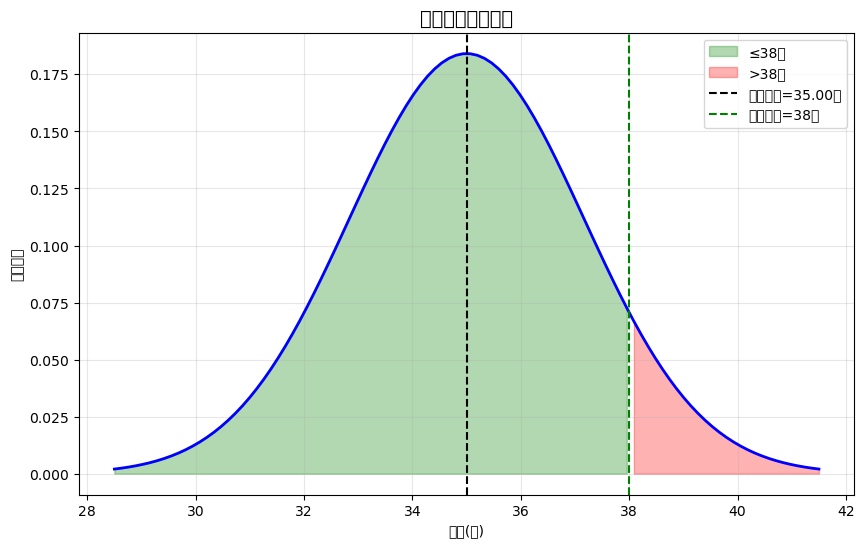

In [5]:
# 创建概率分析表格
prob_df = pd.DataFrame({
    '目标工期(天)': target_days,
    'Z值': [(d - total_duration_pert) / std_dev_pert for d in target_days],
    '完成概率(%)': probabilities
})

display(HTML("<h3>项目工期概率分析</h3>"))
display(prob_df)

# 绘制概率分布图
plt.figure(figsize=(10, 6))
x = np.linspace(total_duration_pert - 3*std_dev_pert, total_duration_pert + 3*std_dev_pert, 100)
y = (1/(std_dev_pert * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - total_duration_pert)/std_dev_pert)**2)

plt.plot(x, y, 'b-', linewidth=2)
plt.fill_between(x, y, where=(x <= 38), color='green', alpha=0.3, label='≤38天')
plt.fill_between(x, y, where=(x > 38), color='red', alpha=0.3, label='>38天')

plt.axvline(x=total_duration_pert, color='k', linestyle='--', label=f'期望工期={total_duration_pert:.2f}天')
plt.axvline(x=38, color='g', linestyle='--', label='目标工期=38天')

plt.title('项目工期概率分布', fontsize=14)
plt.xlabel('工期(天)')
plt.ylabel('概率密度')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

,Activity,Max_Crash,Cost_Per_Day,Current_Duration,Available_Crash,Total_Cost
0,B,2,5000,8,2,10000
2,G,2,6000,7,2,12000
1,D,1,7000,6,1,7000


,Activity,Crash_Days,Cost
0,B,2,10000
1,G,1,6000


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21387 (\N{CJK UNIFIED IDEOGRAPH-538B}) missing from font(

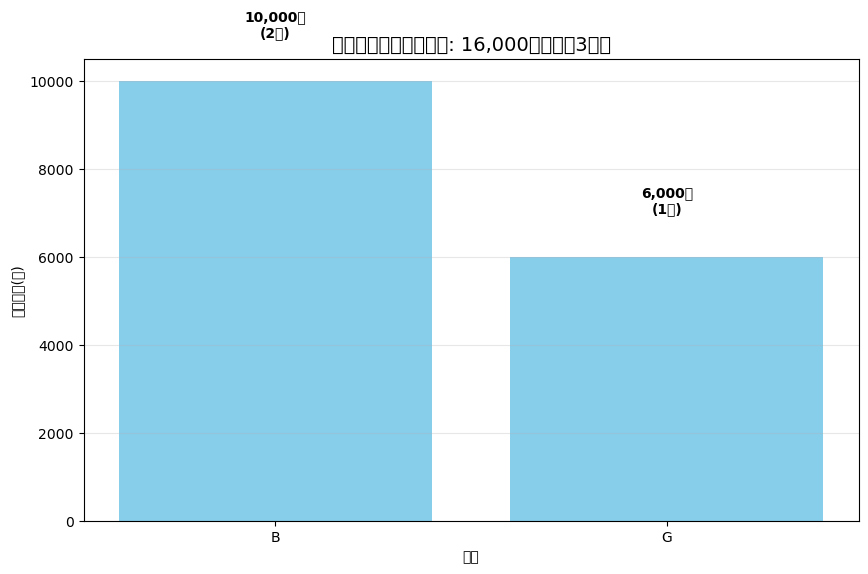

In [8]:
# ======================
# 资源优化示例（工期压缩）
# ======================

def crashing_analysis(df_cpm, crash_data):
    """
    工期压缩分析
    crash_data 字典，格式为 {活动ID: (最大压缩天数, 每天压缩成本)}
    """
    # 只考虑关键路径活动
    critical_activities = df_cpm[df_cpm['Critical'] == '是']['Activity'].tolist()
    
    # 准备压缩数据
    crash_info = []
    for act in critical_activities:
        if act in crash_data:  # 修正：将 crash 改为 crash_data
            max_crash, cost_per_day = crash_data[act]
            crash_info.append({
                'Activity': act,
                'Max_Crash': max_crash,
                'Cost_Per_Day': cost_per_day,
                'Current_Duration': df_cpm.loc[df_cpm['Activity'] == act, 'CPM_Duration'].values[0]
            })
    
    # 创建DataFrame
    crash_df = pd.DataFrame(crash_info)
    
    # 计算可压缩天数和总成本
    crash_df['Available_Crash'] = crash_df['Max_Crash']
    crash_df['Total_Cost'] = crash_df['Available_Crash'] * crash_df['Cost_Per_Day']
    
    # 按成本效率排序（成本/天低的优先压缩）
    crash_df = crash_df.sort_values('Cost_Per_Day')
    
    return crash_df

# 假设的压缩数据：{活动: (最大压缩天数, 每天压缩成本)}
crash_data = {
    'B': (2, 5000),  # 结构框架：最多压缩2天，每天5000元
    'D': (1, 7000),  # 墙体施工：最多压缩1天，每天7000元
    'G': (2, 6000),  # 内部装修：最多压缩2天，每天6000元
    'H': (1, 8000)   # 外部装修：最多压缩1天，每天8000元
}

# 执行工期压缩分析
crash_df = crashing_analysis(df_cpm, crash_data)

display(HTML("<h2>4. 工期压缩(赶工)分析</h2>"))
display(HTML("<p>假设：我们希望将项目工期压缩3天，以下是压缩方案：</p>"))
display(crash_df)

# 计算最优压缩方案
days_to_crash = 3
remaining_days = days_to_crash
crash_plan = []

for _, row in crash_df.iterrows():
    crash_possible = min(row['Available_Crash'], remaining_days)
    if crash_possible > 0:
        crash_plan.append({
            'Activity': row['Activity'],
            'Crash_Days': crash_possible,
            'Cost': crash_possible * row['Cost_Per_Day']
        })
        remaining_days -= crash_possible
        if remaining_days <= 0:
            break

# 创建压缩计划表格
crash_plan_df = pd.DataFrame(crash_plan)
total_crash_cost = crash_plan_df['Cost'].sum()
total_crashed_days = crash_plan_df['Crash_Days'].sum()

display(HTML(f"<p><strong>最优压缩方案（压缩 {total_crashed_days} 天）：</strong></p>"))
display(crash_plan_df)
display(HTML(f"<p><strong>总压缩成本：</strong> {total_crash_cost:,} 元</p>"))
display(HTML(f"<p><strong>压缩后项目工期：</strong> {total_duration_cpm - total_crashed_days} 天（原工期 {total_duration_cpm} 天）</p>"))

# 可视化压缩成本
if not crash_plan_df.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(crash_plan_df['Activity'], crash_plan_df['Cost'], color='skyblue')
    plt.xlabel('活动')
    plt.ylabel('压缩成本(元)')
    plt.title(f'工期压缩方案（总成本: {total_crash_cost:,}元，压缩{total_crashed_days}天）', fontsize=14)
    
    # 在柱子上显示具体数值
    for i, v in enumerate(crash_plan_df['Cost']):
        plt.text(i, v + 1000, f'{v:,}元\n({crash_plan_df["Crash_Days"].iloc[i]}天)', 
                 ha='center', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.show()